$$
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\eq}[1]{Eq.(\ref{eq:#1})}
\newcommand{\zu}[1]{図\ref{fig:#1}}
\newcommand{\shiki}[1]{式(\ref{eq:#1})}
\newcommand{\fig}[1]{Fig.\ \ref{fig:#1}}
\newcommand{\grp}[1]{Fig.\ \ref{grp:#1}}
\newcommand{\tab}[1]{Table\ \ref{tab:#1}}
\newcommand{\defeq}{:=}
\newcommand{\tvec}[1]{\bvec{#1}^{\mathsf{T}}} 
\newcommand{\mr}[1]{\mathrm{#1}}%rm体
\newcommand{\ml}[1]{\mathcal{#1}}%frac体
\newcommand{\bmat}[1]{\begin{bmatrix} #1 \end{bmatrix}}%行列簡略化
\newcommand{\pmat}[1]{\begin{pmatrix} #1 \end{pmatrix}}%行列簡略化
\newcommand{\mat}[1]{\left( \begin{matrix} #1 \end{matrix} \right)}%行列簡略化
%\newcommand{\nom}[1]{ \ml{N} \{ 0,\sigma_{ #1 } \} }
\newcommand{\expo}[1]{ \mathrm{e}^{#1} }
$$
# Stereo + Monocular Depth Estimation
自動運転に限らずカメラを用いた物体の位置認識はロボティクスにおいて重要である。
目的：ステレオカメラ単体で目的とする物体の位置や速度を精度良く測る。

- ステレオ距離測定の問題点
視差を用いているので，差異のわかりづらい，テクスチャの無い箇所からは信用に足るデータを得られない。また，対象が近すぎる場合は位置を推定できない。
私の手持ちのカメラの場合は50cmより近い所は測れない。

- 単眼の問題点
2次元情報のため，絶対的なスケールがわからない。

-- アプローチ
ステレオ距離情報と単眼の拡大縮小情報を適宜組み合わせる手法を考える。


## Previous research
近頃は画像＋レーダーという組み合わせが多々見られる。
ステレオ+画像はいくつかあるが，スケールに着目したものは無さそう。
#### Object Distance Estimation Based on Stereo Vision and Color Segmentation with Region Matching 
https://link.springer.com/content/pdf/10.1007%2F978-3-642-17277-9_38.pdf


## EKFでの推定式
測定したいのは距離$Z$とその速度，それと2次元から3次元へのスケーリング$\lambda$である。従って，状態変数を次のように置く。
$\bm{X}= \mat{\lambda \\ Z \\ \dot{Z}}$
ここで$\lambda=\frac{1}{Z_0}$とする。

システムの更新式は
$$
\dfrac{d}{dt}\mat{\lambda \\ Z \\ \dot{Z}}=\mat{1&0&0\\0&0&1\\0&0&0} \mat{\lambda \\ Z \\ \dot{Z}} + \mat{0 \\ 0\\ 1} \bm{\omega}
$$
システムノイズ$\omega$は観測対象に入るランダムな加速度とする。これで推定するとノイズ有りのカルマンフィルタっぽくなるっぽい？



これをサンプリング$\Delta t$で離散化する。
$$
\mat{\lambda_{n+1}\\ Z_{n+1} \\ \dot{Z}_{n+1}}=\mat{1&0&0\\0&1&\Delta t\\0&0&1} \mat{\lambda_{n}\\ Z_{n} \\ \dot{Z}_{n}} + \mat{0 \\ 0\\ \Delta t}  \bm{\omega}
$$

観測としてまずステレオの視差$D_n$ が考えられる。
$$
D_n = h_1(\lambda_{n},Z_{n} , \dot{Z}_{n})=\frac{BF}{Z_n} + \omega_{h1}
$$
また，二次元のスケーリング（近い物体ほど大きく見える）も同様な観測として考えられる。
$$
scale^{-1} = h_2(\lambda_{n},Z_{n} , \dot{Z}_{n})= \lambda_n Z_n + \omega_{h2}
$$
これらを用いてEKFの式を建てて計算する。
状態変数$\bm{X}_n$でこれらの観測方程式を偏微分すると，次のように表せる。
$$
\dfrac{dh_1}{d\bm{X}_n} =\mat{0 & -\dfrac{BF}{Z_n^2} &0}\\
\dfrac{dh_2}{d\bm{X}_n} =\mat{Z_n & \lambda_n &0}
$$

# シミュレーション

サンプリング33msでシミュレーションします。

In [2]:
%% config
%true depth
% sampling time 
ST = 0.033 %33ms
END = 5.0 % 5sec simulation
STEREO_NOISE_S = 1; % 1px sigma for stereo disparity noise
MONO_NOISE_S = 1; % 1?? sigma for monocular distance estimation noise


ST =

    0.0330


END =

     5




# 真値データ作成
対象は最初$30$cmの距離にあり，振幅$10$cmかつ$1$Hzで振動するとする。

In [3]:
%% make ground truth data 
t = (0:ST:END).'; %time 
len = size(t,1);
freq =0.4;
Z = 0.3 + 0.1*sin(2*pi*freq*t);% 300mm +- 100mm
VZ = 2*pi*freq*0.1*cos(2*pi*freq*t);


# ステレオ視差の観測
ステレオカメラより得られる視差$Disp$は距離$Z$と反比例に関係にあり，焦点距離$F$，ベースライン$B$とを用いて 
\begin{align}
Disp=\frac{BF}{Z}
\end{align} という関係にある。 この観測値に対して，平均が0で分散がSTEREO_NOISE_Sという値で定義されるガウスノイズを載せる。
ステレオカメラでは距離を直接測っているのではなく視差を測っているのでこの方がノイズの扱いとして妥当と考えている。 実際ステレオ距離計測でも近いほどノイズが小さく，遠いほど計測が不確実になる。

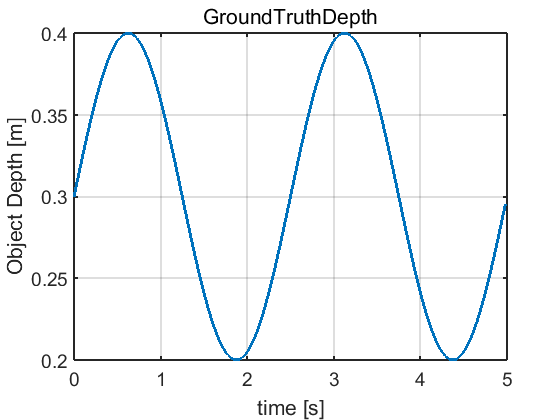

In [4]:
%% Noisy Observation 
BF = 0.065*400; % base line * focal length
StereoNoise = STEREO_NOISE_S * randn(length(t),1);
Disp = BF./Z + StereoNoise;
Zlim = 0.3;

mDisp = Disp;
INFF = 1000000000;
mDisp(mDisp>BF/Zlim) = INFF;

figure(1);
plot(t,Z)
title('GroundTruthDepth')
xlabel('time [s]')
ylabel('Object Depth [m]')
grid on;

なお，今回は距離$Z$が25cmより近い時にステレオカメラが距離を測れないことを模擬する。


Z0 =

    0.3000


IMG_SIZE =

   300




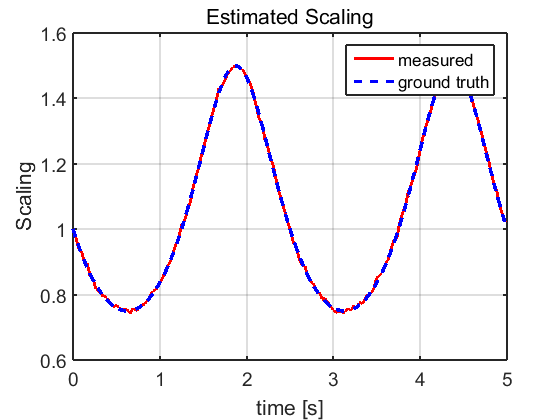

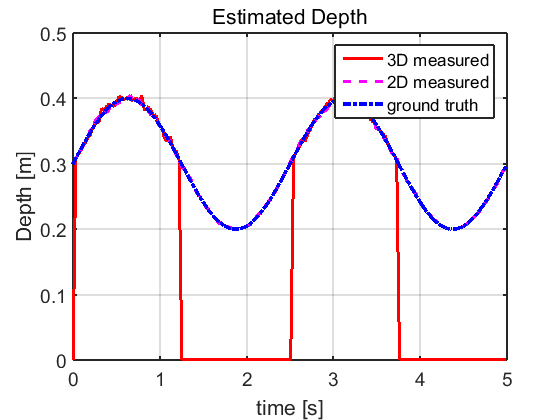

In [5]:
%% Noisy Monocluar Obserbation
Z0 = 0.3 % the real distance template is taken
IMG_SIZE = 600/2% 300 times 300 pix template
MonoNoise = MONO_NOISE_S*randn(length(t),1); % sigma = 1px image noise 
Snoise = 2./(Z0./Z * IMG_SIZE).* MonoNoise;
Scale = Z0./Z + Snoise;
dScale = [1; Scale(2:length(t))./Scale(1:length(t)-1)];

figure(2)
plot(t,BF./mDisp,'r',t,Z0./Scale,'m--',t,Z,'b-.')
title('Estimated Depth')
xlabel('time [s]')
ylabel('Depth [m]')
legend('3D measured','2D measured','ground truth')
grid on;


figure(3);
plot(t,Scale,'r',t,Z0./Z,'b--')
title('Estimated Scaling')
xlabel('time [s]')
ylabel('Scaling')
legend('measured','ground truth')
grid on;

これらのデータからEKF推定をする。

## ステレオ推定のみの場合
ステレオの推定のみの場合のシミュレーションを以下に示す。

In [6]:
%% system matrix
A = [ 1,0,0;0,1,ST;0,0,1];
B = [0; ST^2/2; ST];
Q = B*B.';
% Measurment Covariance
R1 = STEREO_NOISE_S * 1;
R2 = 0.5;

%% init
Pinit = diag([100,100,100]);
lam0 = 1/Scale(1)/Z(1);
Xinit = [lam0 Z(1) VZ(1)];

P = zeros(3,3,length(t));
X = zeros(3,length(t));
KG = zeros(3,2,length(t));
P(:,:,1) = Pinit;
X(:,1) = Xinit;


%%
BF_ = BF;
for i=2:length(t)
    % Estimate
    Xhat = A * X(:,i-1);
    Phat = A*P(:,:,i-1)*A.' + Q;

    
    
    
    % Switch value
    if mDisp(i)== INFF
        R1_ = INFF*INFF; mD=0;
    else
        R1_ = R1; mD = mDisp(i);        
    end
    H1 = [0 -BF_/Xhat(2)/Xhat(2) 0];
    %H1 = [0 -mD/Xhat(2) 0];
    %H1 = [0 -mD^2/BF_ 0];
    
    % KF gain
    Kgain = Phat * H1.' / (H1*Phat*H1.'+R1_);
    % update
    Xnew =  Xhat + Kgain*(mDisp(i) - BF_/Xhat(2));
    Pnew = (eye(3) - Kgain*H1)*Phat ;

    
    X(:,i) = Xnew;
    P(:,:,i) = Pnew;
    KG(:,1,i)=Kgain;
    %KG(:,2,i)=Kgain2;
end

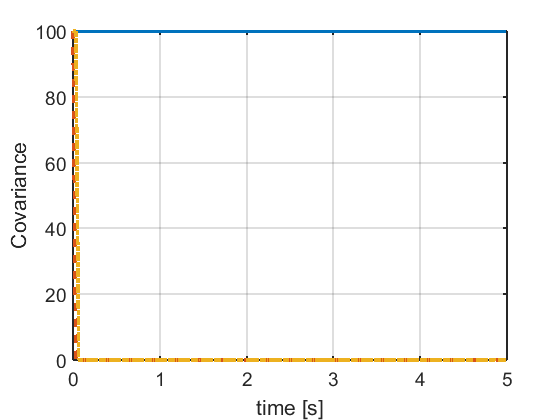

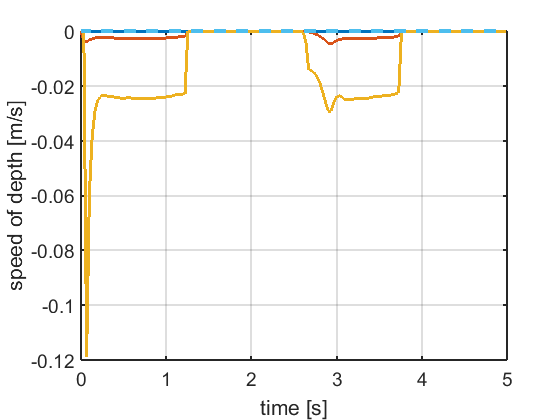

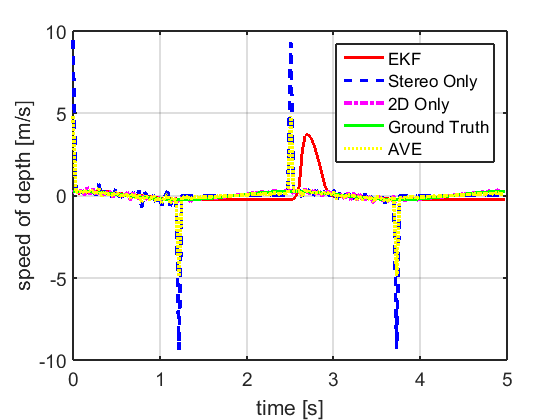

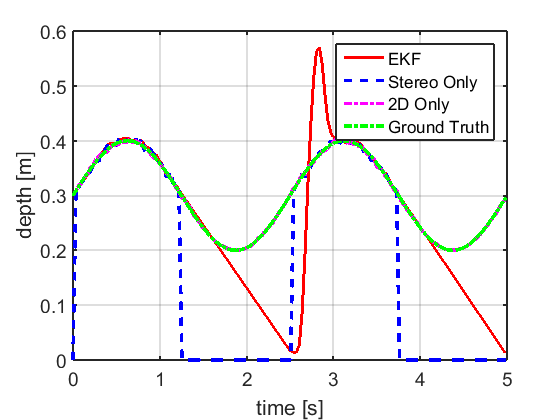

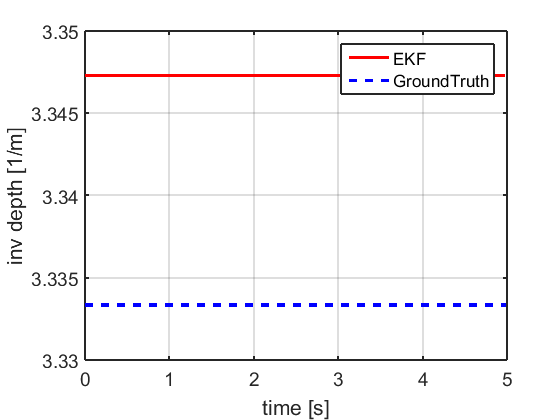

In [8]:
showResult

上から共分散，カルマンゲイン，速度，距離，スケーリングの推定である。

カルマンフィルタはノイズを平滑化できるが，情報のない区間は等速運動として推定してしまう。

## 2Dスケーリングのみの観測
2Dスケール情報を用いた修正には問題が存在する。本来一定量である$Z_0$と変化量である$Z_n$とを同様に更新するため，単独で用いた場合にはどちらの変数も同時に変更してしまう。
とりあえず結果を見てみよう。



In [9]:

%% system matrix
A = [ 1,0,0;0,1,ST;0,0,1];
B = [0; ST^2/2; ST];
Q = B*B.';
% Measurment Covariance
R1 = STEREO_NOISE_S;
R2 = 0.005;

%% init
Pinit = diag([100,100,100]);
lam0 = 1/Scale(1)/Z(1);
Xinit = [lam0 Z(1) VZ(1)];

P = zeros(3,3,length(t));
X = zeros(3,length(t));
KG = zeros(3,2,length(t));
P(:,:,1) = Pinit;
X(:,1) = Xinit;


%%
BF_ = BF;
for i=2:length(t)
    % Estimate
    Xhat = A * X(:,i-1);
    Phat = A*P(:,:,i-1)*A.' + Q;

    
    
    
    % Switch value
    if mDisp(i)== INFF
        R1_ = INFF*INFF; mD=0;
    else
        R1_ = R1; mD = mDisp(i);        
    end
    %H1 = [0 -BF_/Xhat(2)/Xhat(2) 0];
    %H1 = [0 -mD/Xhat(2) 0];
    %H1 = [0 -mD^2/BF_ 0];

    H2 = [Xhat(2) Xhat(1) 0];
    
    
    Kgain = Phat * H2.' / (H2*Phat*H2.'+R2/10000);
    % update 2
    Xnew =  Xhat + Kgain*(1/Scale(i) - Xhat(1) *Xhat(2));
    Pnew = (eye(3) - Kgain*H2)*Phat;

    
    X(:,i) = Xnew;
    P(:,:,i) = Pnew;
    KG(:,1,i)=Kgain;
    %KG(:,2,i)=Kgain2;
end



こちらも結果を図示しよう。
上から共分散，カルマンゲイン，速度，距離，スケーリングの推定である。
カルマンフィルタはノイズを平滑化できるのは同様だが，Zの推定と同時に一定量であるはずのスケーリングも変更してしまう。


ステレオの更新がない場合は$\lambda$をただの定数として，
次のようにしたほうが良さそう。
$$
scale^{-1} = h_2'(\lambda_{n},Z_{n} , \dot{Z}_{n})= \lambda Z_n + \omega_{h2}\\
\dfrac{dh_2’}{d\bm{X}_n} =\mat{0 & \hat\lambda &0}
$$


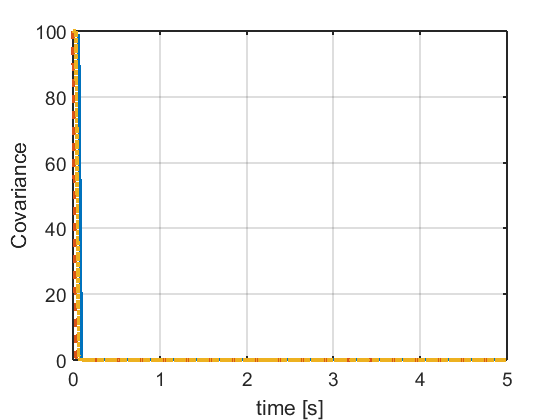

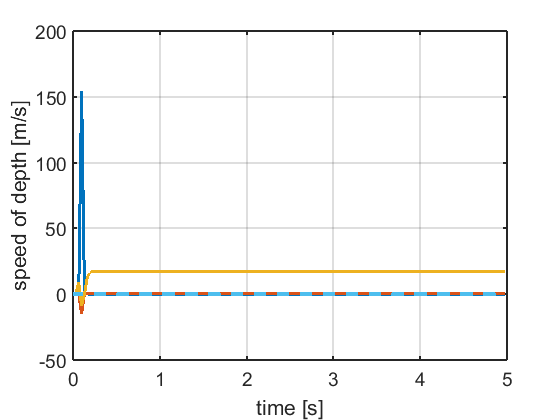

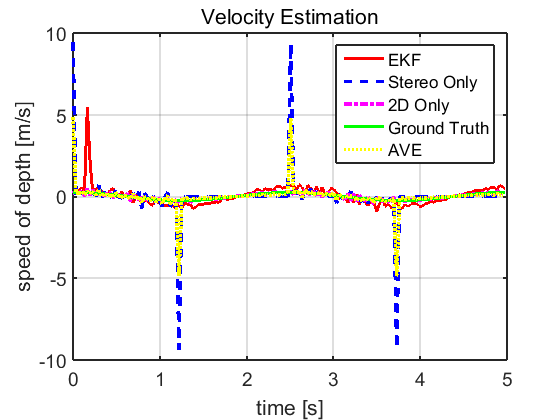

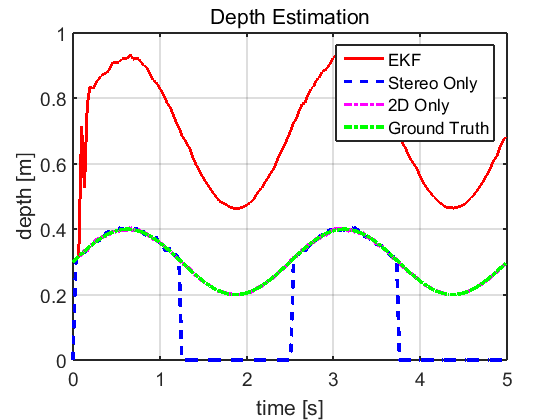

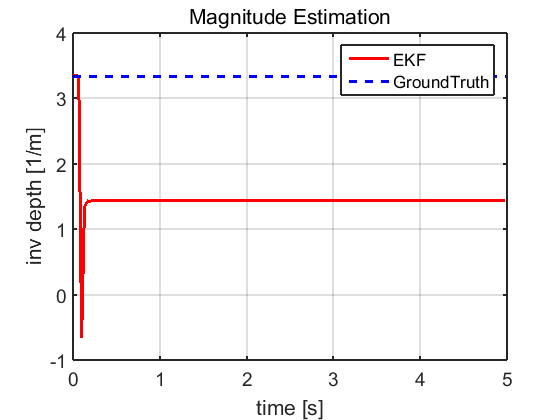

In [10]:
%% figure
showResult

## 観測ノイズと位相遅れに関する考察

修正した2Dスケーリングの観測において，観測ノイズ$R_2$を大きく取ると観測のノイズを大きく推定するためにローパスのようなフィルタ効果が強くかかる。従って次のように位相遅れが大きくなる。

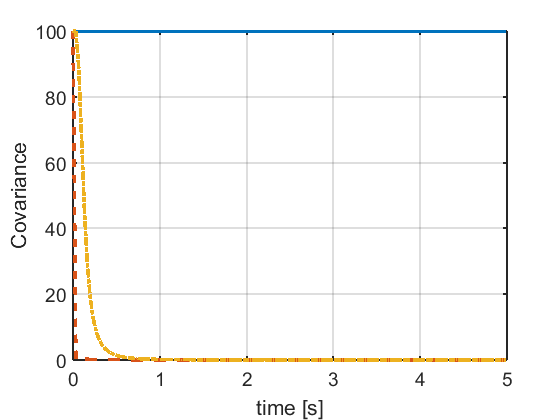

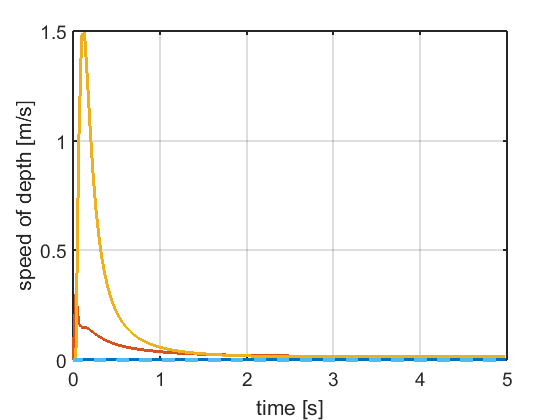

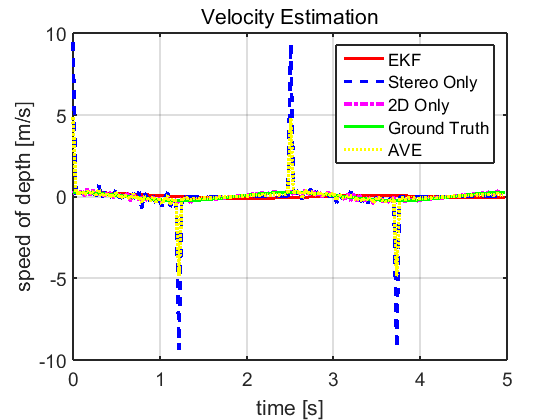

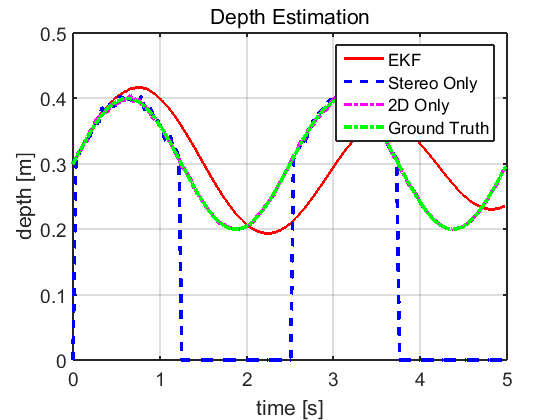

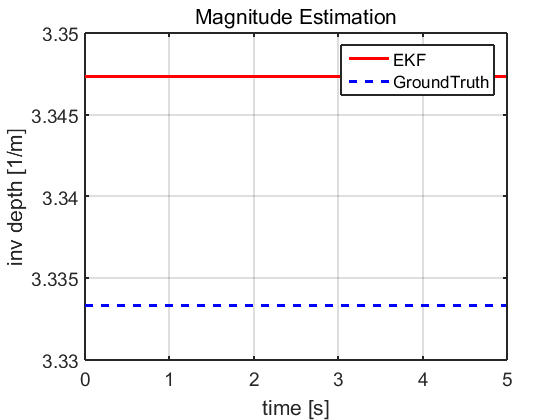

In [11]:

%% system matrix
A = [ 1,0,0;0,1,ST;0,0,1];
B = [0; ST^2/2; ST];
Q = B*B.';
% Measurment Covariance
R1 = STEREO_NOISE_S;
R2 = 5;

%% init
Pinit = diag([100,100,100]);
lam0 = 1/Scale(1)/Z(1);
Xinit = [lam0 Z(1) VZ(1)];

P = zeros(3,3,length(t));
X = zeros(3,length(t));
KG = zeros(3,2,length(t));
P(:,:,1) = Pinit;
X(:,1) = Xinit;


%%
BF_ = BF;
for i=2:length(t)
    % Estimate
    Xhat = A * X(:,i-1);
    Phat = A*P(:,:,i-1)*A.' + Q;
    
    % Switch value
    if mDisp(i)== INFF
        R1_ = INFF*INFF; mD=0;
    else
        R1_ = R1; mD = mDisp(i);        
    end
    %H1 = [0 -BF_/Xhat(2)/Xhat(2) 0];
    %H1 = [0 -mD/Xhat(2) 0];
    H1 = [0 -mD^2/BF_ 0];

    H2 = [0 1/Z0 0];
    
    
    Kgain = Phat * H2.' / (H2*Phat*H2.'+R2);
    % update 2
    Xnew =  Xhat + Kgain*(1/Scale(i) - 1/Z0 *Xhat(2));
    Pnew = (eye(3) - Kgain*H2)*Phat;

    
    X(:,i) = Xnew;
    P(:,:,i) = Pnew;
    KG(:,1,i)=Kgain;
    %KG(:,2,i)=Kgain2;
end


%% figure
showResult


一方で観測誤差を小さくすると位相遅れの効果を小さくすることができるが特に速度の観測がNoisyになる。
$R_2 = 0.0005$

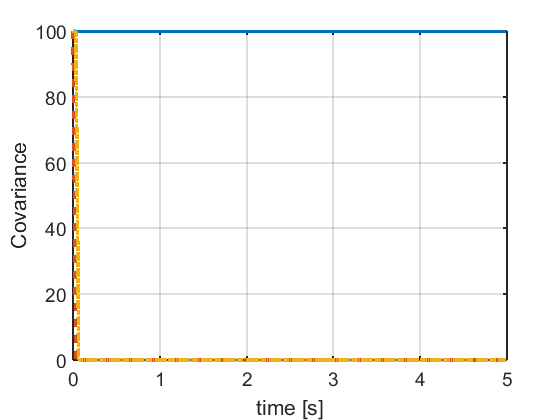

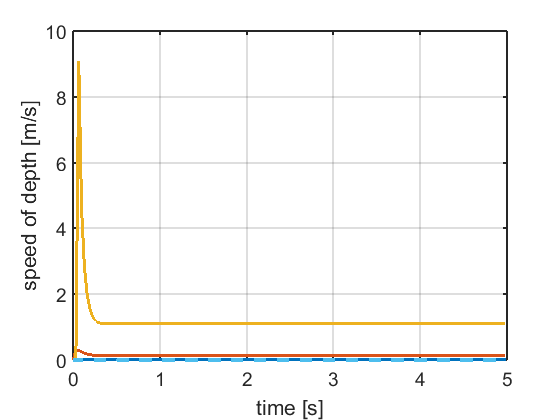

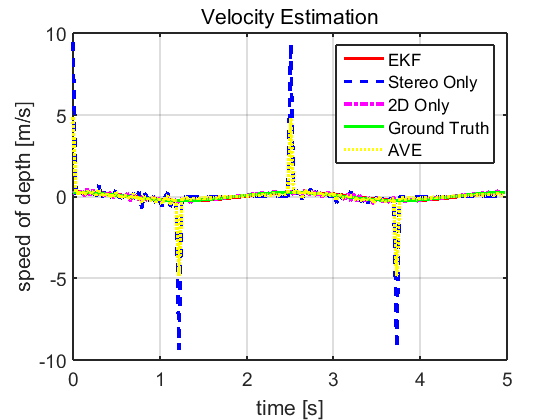

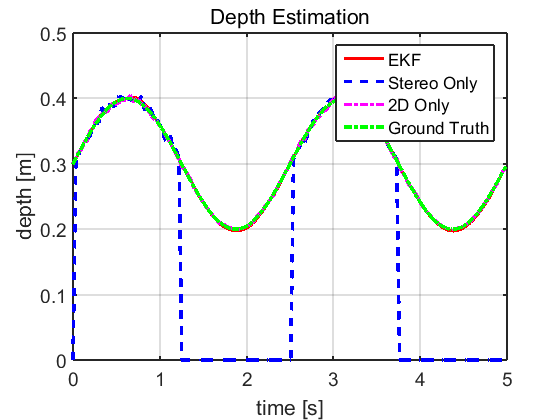

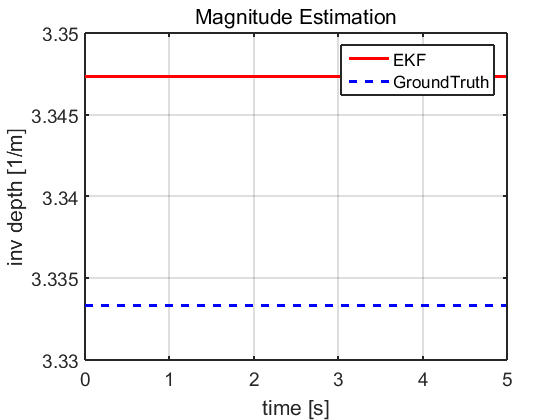

In [12]:

%% system matrix
A = [ 1,0,0;0,1,ST;0,0,1];
B = [0; ST^2/2; ST];
Q = B*B.';
% Measurment Covariance
R1 = STEREO_NOISE_S;
R2 = 0.0005;

%% init
Pinit = diag([100,100,100]);
lam0 = 1/Scale(1)/Z(1);
Xinit = [lam0 Z(1) VZ(1)];

P = zeros(3,3,length(t));
X = zeros(3,length(t));
KG = zeros(3,2,length(t));
P(:,:,1) = Pinit;
X(:,1) = Xinit;


%%
BF_ = BF;
for i=2:length(t)
    % Estimate
    Xhat = A * X(:,i-1);
    Phat = A*P(:,:,i-1)*A.' + Q;
    
    % Switch value
    if mDisp(i)== INFF
        R1_ = INFF*INFF; mD=0;
    else
        R1_ = R1; mD = mDisp(i);        
    end
    %H1 = [0 -BF_/Xhat(2)/Xhat(2) 0];
    %H1 = [0 -mD/Xhat(2) 0];
    H1 = [0 -mD^2/BF_ 0];

    H2 = [0 1/Z0 0];
    
    
    Kgain = Phat * H2.' / (H2*Phat*H2.'+R2);
    % update 2
    Xnew =  Xhat + Kgain*(1/Scale(i) - 1/Z0 *Xhat(2));
    Pnew = (eye(3) - Kgain*H2)*Phat;

    
    X(:,i) = Xnew;
    P(:,:,i) = Pnew;
    KG(:,1,i)=Kgain;
    %KG(:,2,i)=Kgain2;
end


%% figure
showResult

# 2つの観測を持ったEKFの実装
ステレオと2Dのスケーリングの観測を合わせたEKFを以下に示す。
順番は恐らく関係ないはず…


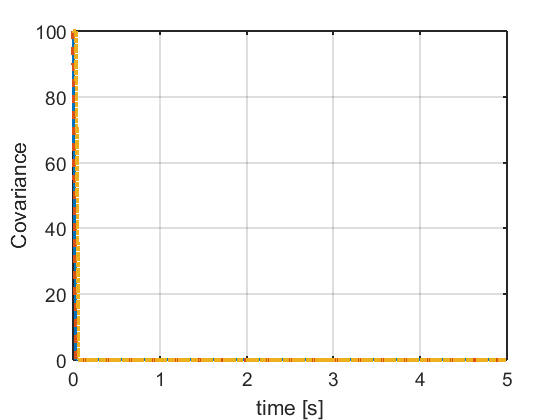

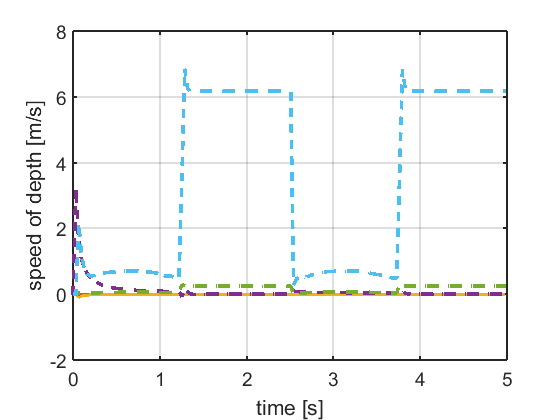

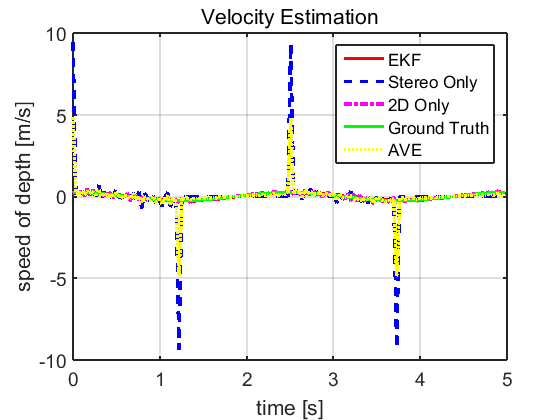

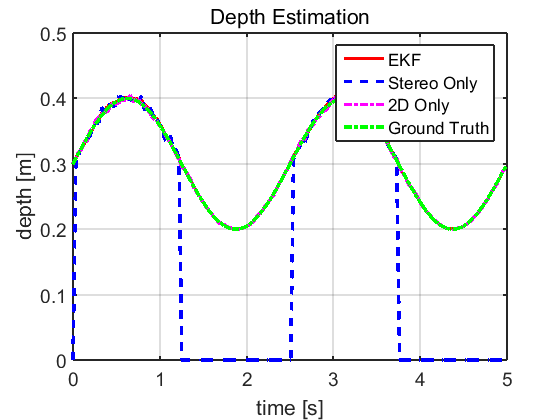

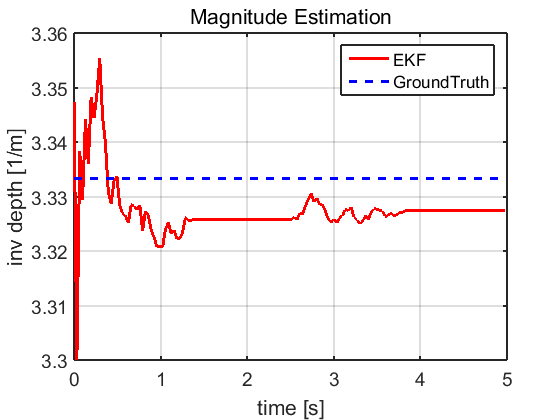

In [13]:

%% system matrix
A = [ 1,0,0;0,1,ST;0,0,1];
B = [0; ST^2/2; ST];
Q = B*B.';
% Measurment Covariance
R1 = STEREO_NOISE_S;
R2 = 0.0005;

%% init
Pinit = diag([100,100,100]);
lam0 = 1/Scale(1)/Z(1);
Xinit = [lam0 Z(1) VZ(1)];

P = zeros(3,3,length(t));
X = zeros(3,length(t));
KG = zeros(3,2,length(t));
P(:,:,1) = Pinit;
X(:,1) = Xinit;

%%
BF_ = BF;
for i=2:length(t)
    % Estimate
    Xhat = A * X(:,i-1);
    Phat = A*P(:,:,i-1)*A.' + Q;
    
    % Switch value
    if mDisp(i)== INFF
        R1_ = INFF*INFF; mD=0; R2_=R2/100;
    else
        R1_ = R1; mD = mDisp(i); R2_=R2;  
    end
    %H1 = [0 -BF_/Xhat(2)/Xhat(2) 0];
    %H1 = [0 -mD/Xhat(2) 0];
    H1 = [0 -mD^2/BF_ 0];
    
    % KF gain
    Kgain = Phat * H1.' / (H1*Phat*H1.'+R1_);
    % update
    Xhat2 =  Xhat + Kgain*(mDisp(i) - BF_/Xhat(2));
    Phat2 = (eye(3) - Kgain*H1)*Phat ;

    if mDisp(i)== INFF
        R2_=R2/100;
        H2 = [0 Xhat2(1) 0];
    else
        R2_=R2;
        H2 = [Xhat2(2) Xhat2(1) 0];    
    end
    
    
    Kgain2 = Phat2 * H2.' / (H2*Phat2*H2.'+R2_);
    % update 2
    Xnew =  Xhat2 + Kgain2*(1/Scale(i) - Xhat2(1)*Xhat2(2));
    Pnew = (eye(3) - Kgain2*H2)*Phat2;
    X(:,i) = Xnew;
    P(:,:,i) = Pnew;
    KG(:,1,i)=Kgain;
    KG(:,2,i)=Kgain2;
end


%%
showResult

## 結論
単体でやるよりEKFでやった方がいいという直感的な間隔を確かめられた。
誤差の共分散行列の設定によって推定値の位相遅れとノイズへの頑強性がトレードオフになるということも確認できる。
中途半端な値にすると収束しなかったりでこの辺りの設計には慣れが必要っぽい。